In [3]:
#data format library
import h5py

#numpy
import numpy as np
import pandas as pd
import numpy.ma as ma
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams["font.family"] = "Times New Roman"
# %matplotlib notebook
import sys
sys.path.append('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/')
import matplotlib.colors as pltcolors
import os
import copy
import clustering_methods as cl
import operator_calculations as op_calc
import delay_embedding as embed
import stats
import time

np.random.seed(42)

import importlib
importlib.reload(op_calc)

<module 'operator_calculations' from '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/operator_calculations.py'>

## PCA

In [5]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_data/'
f = h5py.File(path_to_filtered_data+'pool_ex8_PCs.h5','r')
lengths_data = np.array(f['MetaData/lengths_data'], dtype=int)
pca_fish = ma.array(f['pca_fish'])
data_means = ma.array(f['data_means'])
eigvecs = ma.array(f['eigvecs'])
cov = ma.array(f['cov'])
var_exp = np.array(f['var_exp'])
max_shuffs = np.array(f['max_shuffs'])
f.close()

In [6]:
var_exp = np.reshape(var_exp, (var_exp.shape[0]*var_exp.shape[1], 1400))

In [7]:
m, cil, ciu = stats.bootstrap(var_exp, n_times = 1000)

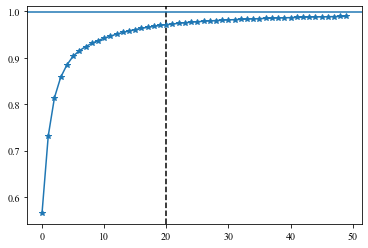

In [8]:
# plt.plot(m[:50])
plt.errorbar(np.arange(0,50), m[:50], [m[:50] - cil[:50],ciu[:50] - m[:50]], fmt='-*')
plt.axvline(20, ls = '--', c='k')
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl1/var_exp.pdf')
plt.axhline(1-max_shuffs[0,0])
# plt.fill_between
# plt.xlim(0,300)

In [9]:
eigvecs = 180*(eigvecs/np.pi)

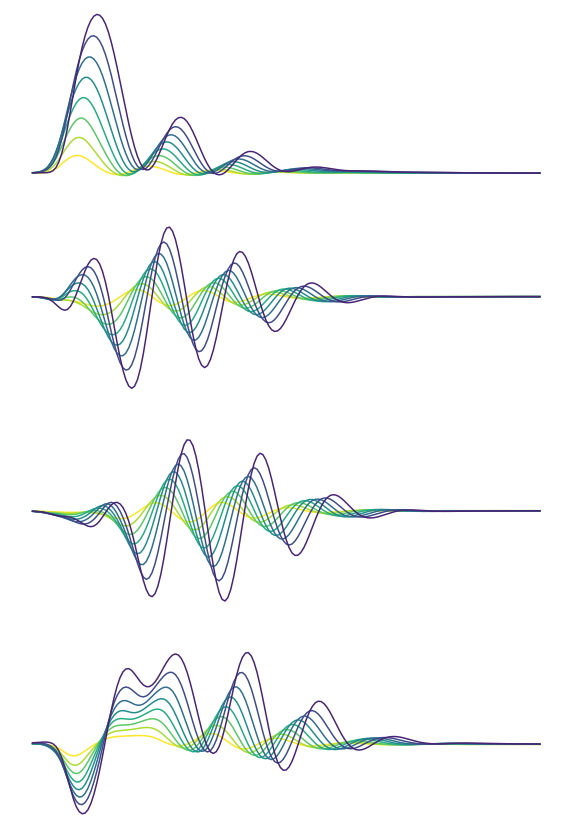

In [10]:
fig,ax = plt.subplots(4,1,figsize=(10,15))

colors_ = plt.cm.viridis_r(np.linspace(0,0.9,8))
# for i in range(8):
for i in range(8):
    ax[0].plot(eigvecs[:,0].reshape(175,8)[:,i],color = colors_[i])
    ax[1].plot(eigvecs[:,1].reshape(175,8)[:,i],color = colors_[i])
    ax[2].plot(eigvecs[:,2].reshape(175,8)[:,i],color = colors_[i])
    ax[3].plot(eigvecs[:,3].reshape(175,8)[:,i],color = colors_[i])
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
# plt.colorbar()
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl1/4pcs.pdf')
plt.show()

## Entropy

In [12]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_data/'
f1 = h5py.File(path_to_filtered_data+'Entropy_seeds_delays_clusters.h5','r')
total_entropy= np.array(f1['entropies'],dtype=float)
f1.close()

In [13]:
print(total_entropy.shape)

(100, 9, 22)


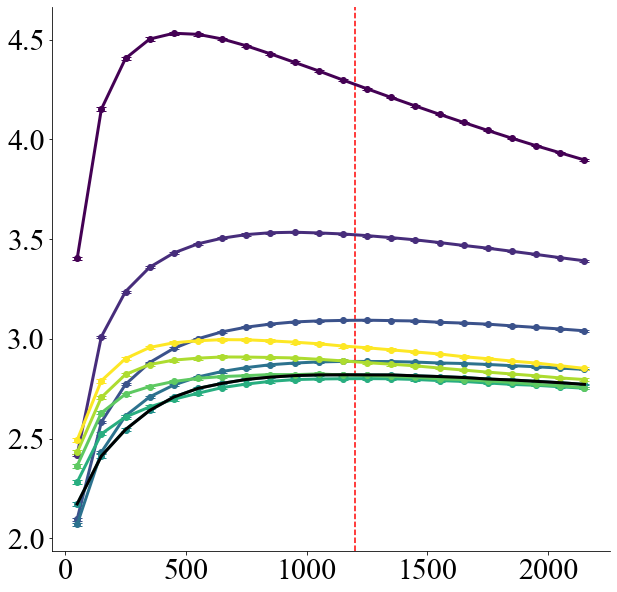

In [14]:
K_range = np.arange(1,10)
n_clusters = np.arange(50,2250,100)

colors_ = plt.cm.viridis(np.linspace(0,1,K_range.shape[0]))
# colors_ = plt.cm.Reds(np.linspace(0,1,n_clusters.shape[0]))
# colors_ = plt.cm.viridis(np.linspace(0,1,10))

fig,ax = plt.subplots(1,1,figsize=(10,10))
for k in range(K_range.shape[0]):
    mean,cil,ciu = stats.bootstrap(total_entropy[:,k,:].squeeze(),n_times=1000)
    ax.errorbar(n_clusters,mean,[mean-cil,ciu-mean],marker='o', color=colors_[k], lw = 3, elinewidth=3, capsize=5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
ax.axvline(1200,ls='--',c='r')
mean_seed,cil, ciu = stats.bootstrap(total_entropy[:,4,:], n_times=1000)
ax.plot(n_clusters,mean_seed, color='k',label= r'Delay $K = 5$', lw=3, alpha=1.0, zorder=10)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Fig1/Entropy_nflip_K_N1000.pdf')
plt.show()